# Imports #

## Libraries ##

In [1]:
import pandas as pd
import numpy as np
import itertools
from scipy import linalg
from scipy.misc import derivative
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib import offsetbox
from matplotlib.ticker import NullFormatter
import seaborn as sns
from time import time

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import MDS, Isomap, TSNE
from sklearn.cluster import KMeans, DBSCAN, OPTICS, cluster_optics_dbscan
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, homogeneity_score, \
completeness_score, adjusted_rand_score, davies_bouldin_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Fonctions for later ##

Coming from the GitHub of Ritchieng.

In [2]:
# Fonctioms from Ritchieng from GitHub

def pca_results(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar', color=list(mcolors.CSS4_COLORS));
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

def cluster_results(reduced_data, preds, centers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = plt.cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	# Plot transformed sample points 
	ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
	           s = 150, linewidth = 4, color = 'black', marker = 'x');

	# Set plot title
	ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

## Dataset ##

In [3]:
data_df = pd.read_csv('Ressources' + '/' + 'reference_antoine.csv')

data_df.drop(columns=['Unnamed: 0'], inplace=True)
#data_df.reset_index(drop=True, inplace=True)

data_df = data_df.iloc[:,0:34]
data_df

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,order_id,order_purchase_timestamp,nb_day_delivery_est,nb_day_delivery_diff_est,...,nb_orders,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,price,freight_value,product_vol,order_nb_products,price_log
0,0.0,7787,636.0,25.0,-23.335331,-46.828647,75221.0,2018-05-10 10:56:27,10.0,-4.0,...,1,60.0,236.0,1.0,1500.0,129.90,12.00,7616.0,1,4.874434
1,1.0,6053,2517.0,25.0,-23.567395,-46.792957,17759.0,2018-05-07 11:11:27,7.0,-4.0,...,1,56.0,635.0,1.0,375.0,18.90,8.29,5148.0,1,2.990720
2,2.0,88115,3406.0,23.0,-27.543787,-48.625680,59381.0,2017-03-10 21:05:03,27.0,-2.0,...,1,49.0,177.0,3.0,1500.0,69.00,17.22,43750.0,1,4.248495
3,3.0,66812,435.0,13.0,-1.311011,-48.482884,21568.0,2017-10-12 20:29:41,31.0,-11.0,...,1,43.0,1741.0,5.0,150.0,25.99,17.63,1045.0,1,3.295466
4,4.0,18040,3637.0,25.0,-23.504368,-47.466156,72171.0,2017-11-14 19:45:42,20.0,-7.0,...,1,58.0,794.0,3.0,6050.0,180.00,16.89,528.0,1,5.198497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84989,84989.0,28909,592.0,18.0,-22.899295,-42.046346,7206.0,2018-04-11 00:34:32,27.0,-12.0,...,1,43.0,378.0,2.0,867.0,688.00,22.70,1960.0,1,6.535241
84990,84990.0,44054,1280.0,4.0,-12.221792,-38.962517,66104.0,2017-12-10 20:07:56,32.0,-2.0,...,1,37.0,506.0,2.0,1720.0,64.89,19.69,32076.0,1,4.187987
84991,84991.0,78552,3620.0,12.0,-11.829317,-55.496443,84265.0,2017-02-07 15:49:16,44.0,-30.0,...,1,57.0,716.0,5.0,600.0,89.90,22.56,3315.0,1,4.509760
84992,84992.0,29460,502.0,7.0,-21.125061,-41.666268,49125.0,2018-05-02 15:17:41,25.0,-14.0,...,1,35.0,591.0,3.0,444.0,115.00,18.69,4480.0,1,4.753590


# Preprocessing the Data #

## Basic Informations ##

In [4]:
# Dataset Informations
print("Dataset's size : {}\n\nColumns' Names\n{}"
      .format(np.shape(data_df),[k for l,k in enumerate(data_df.columns)]))

Dataset's size : (84994, 34)

Columns' Names
['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'geolocation_lat', 'geolocation_lng', 'order_id', 'order_purchase_timestamp', 'nb_day_delivery_est', 'nb_day_delivery_diff_est', 'nb_day_delivery', 'order_purchase_year', 'order_purchase_month', 'order_purchase_dayofweek', 'order_purchase_hour', 'month_year', 'month_y', 'review_score', 'payment_credit_card', 'payment_boleto', 'payment_voucher', 'payment_debit_card', 'tot_order_log', 'nb_day_review', 'nb_orders', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'price', 'freight_value', 'product_vol', 'order_nb_products', 'price_log']


## Initializing Variables ##

In [5]:
numerical_columns = [k for k in data_df.columns]
numerical_columns.remove('order_purchase_timestamp')

categorical_columns = ['order_purchase_timestamp']

## Pipelines ##

We will first define some pipelines used for the preprocessing. Here, we will transform the strings in numbers and rescale the numerical variables.

In [6]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)),
    #('encoder', OneHotEncoder(handle_unknown='ignore')),
    #('encoder', LabelEncoder()),
    ('scaler', RobustScaler(with_centering=False))
    ])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', RobustScaler())
    ])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)
    ])

## Preprocessing in itself ##

In [7]:
X = data_df
X = preprocessing.fit_transform(X)

# All the data #

## Reducing the Data ##

We will now look into reducing the data to be able to visualise it and to simplify the segmentation. We will try several methods of reduction to see what work the best.

### PCA ###

We will first try with a PCA since it is one of the most common dimension reduction tool.

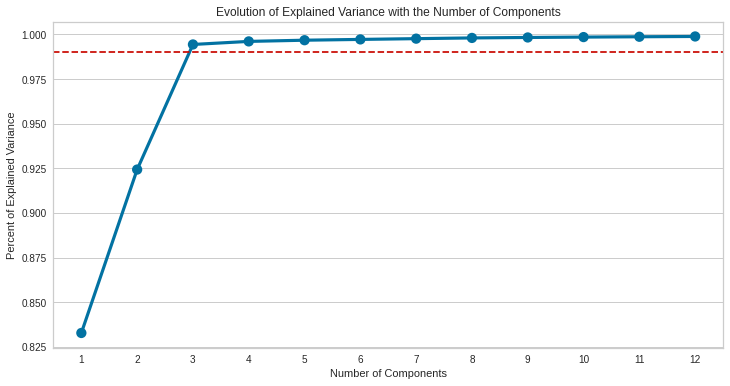

In [8]:
pca_df = pd.DataFrame(columns=['components_number', 'explained_variance'])

for i in range(1,13):
    pca_df.loc[i-1, 'components_number'] = i
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X)
    pca_df.loc[i-1, 'explained_variance'] = pca.explained_variance_ratio_.sum()

f, ax = plt.subplots(figsize=(12,6))

sns.pointplot(x='components_number', 
              y='explained_variance', 
              data=pca_df, 
              markers=['o'], 
              linestyles=['-'])

plt.axhline(y=0.99, color='r', linestyle='--')

plt.title('Evolution of Explained Variance with the Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Percent of Explained Variance')
plt.show()

As we can see, the dataset can be explained even with only one component, which simplifies it a lot.

We will then keep 2 components. (mainly for ease of representation)

In [9]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)

print('Percentage of variance explained by each component : \n{}\n'.format(pca.explained_variance_ratio_))
print('Sum of it:\n{}'.format(pca.explained_variance_ratio_.sum()))

Percentage of variance explained by each component : 
[8.32751512e-01 9.15458241e-02 7.00788016e-02 1.71534785e-03
 6.69341968e-04 4.46855144e-04]

Sum of it:
0.9972076822913197


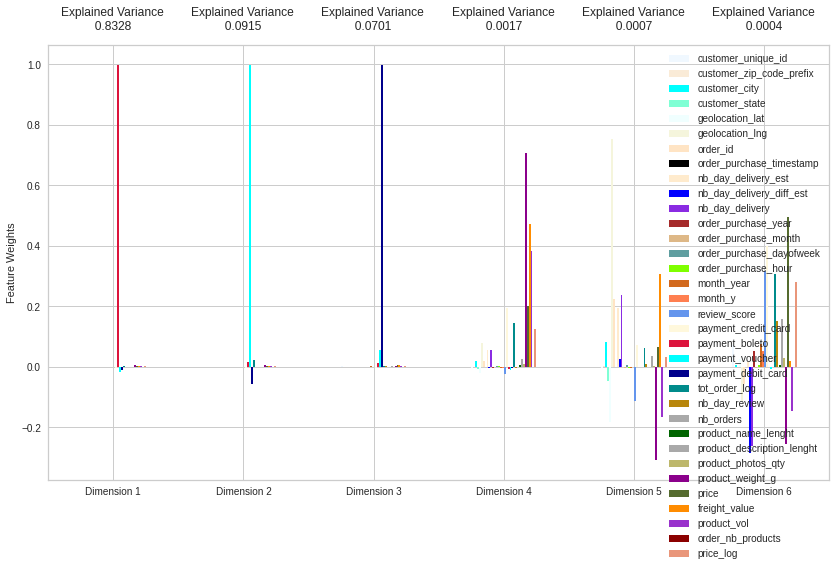

In [10]:
pca_results = pca_results(data_df, pca)

In [12]:
# DataFrame of results
display(pca_results)

# DataFrame
display(type(pca_results))

# Cumulative explained variance should add to 1
display(pca_results['Explained Variance'].cumsum())

,Explained Variance,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,order_id,order_purchase_timestamp,nb_day_delivery_est,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Dimension 1,0.8321,-0.0002,-0.0001,0.0004,-0.0001,-0.0001,0.0005,-0.0003,0.0000,0.0007,...,0.0,0.0,0.0000,0.0,-0.0,-0.0,-0.0,-0.0000,0.0000,0.0
Dimension 2,0.0915,-0.0005,-0.0000,0.0003,-0.0001,-0.0002,0.0009,0.0004,-0.0003,0.0010,...,0.0,-0.0,0.0001,0.0,0.0,0.0,-0.0,-0.0001,0.0001,-0.0


pandas.core.frame.DataFrame

Dimension 1    0.8321
Dimension 2    0.9236
Name: Explained Variance, dtype: float64

### MDS and Isomap ###

We tried these method of reduction as well but our dataset was too big and too much RAM was needed for the computer to handle.

### t-SNE ###

In [19]:
tsne = TSNE(n_components=2, perplexity=300, n_iter=600, init='pca')
t0 = time()
X_tsne = tsne.fit_transform(X)
t1 = time()

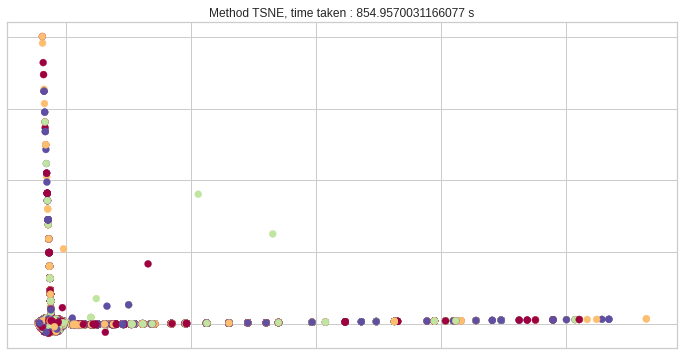

In [20]:
fig, ax = plt.subplots(figsize = (12,6))
colour = np.random.randint(1, 5, size=len(X_tsne))

ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colour ,cmap=plt.cm.Spectral)
ax.set_title('Method TSNE, time taken : {} s'.format(t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis('tight')

plt.show()

## Testing Differents Unspervised Algorithms ##

### K-Means ###

#### Testing ####

##### Without the PCA #####

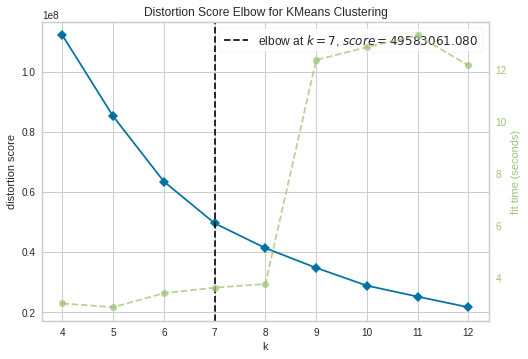

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))

visualizer.fit(X)
visualizer.poof()

Number of Clusters : 6



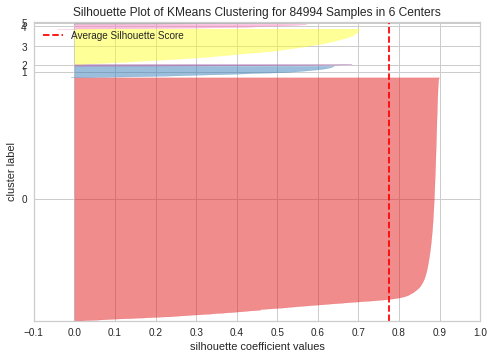

Number of Clusters : 7



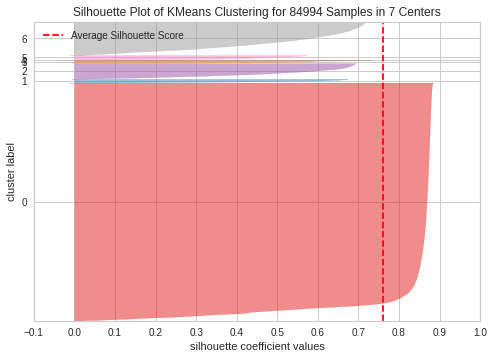

Number of Clusters : 8



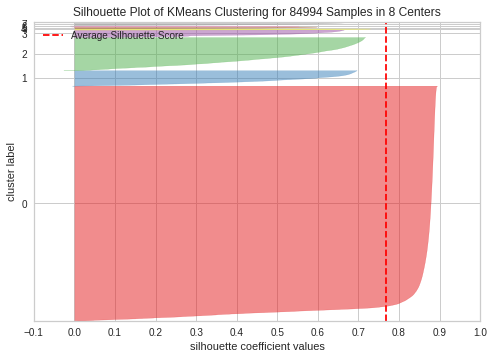

Number of Clusters : 9



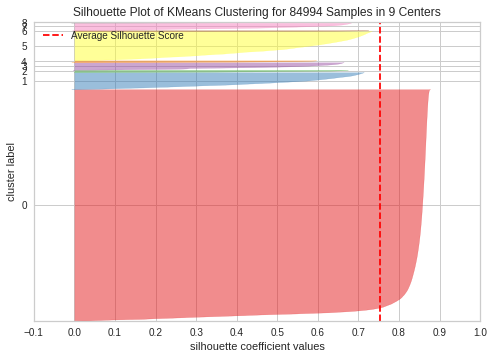

Number of Clusters : 10



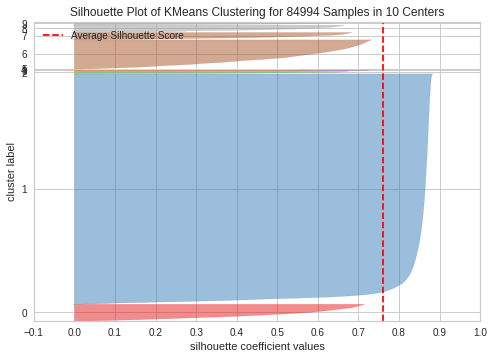

In [30]:
for i in range(6,11):
    print('Number of Clusters : {}\n'.format(i))
    model = KMeans(i)
    visualizer = SilhouetteVisualizer(model)
    
    visualizer.fit(X)
    visualizer.poof()

##### With the PCA #####

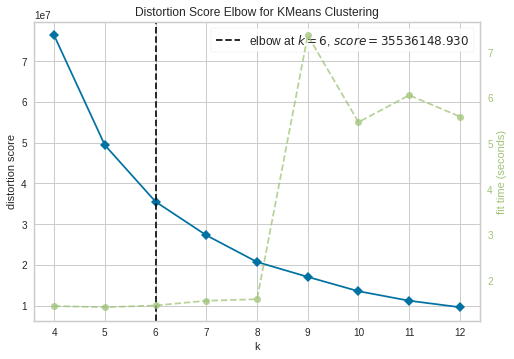

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))

visualizer.fit(X_pca)
visualizer.poof()

Number of Clusters : 6



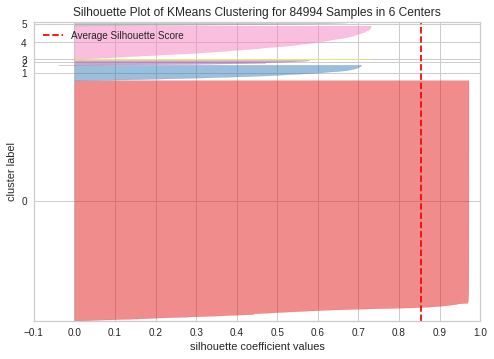

Number of Clusters : 7



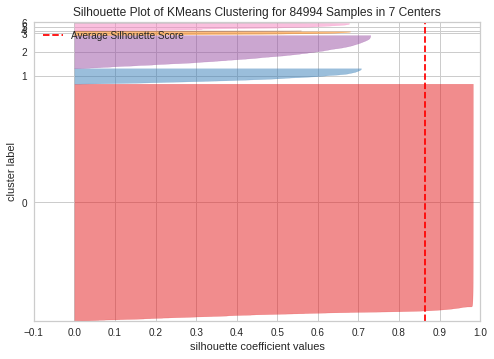

Number of Clusters : 8



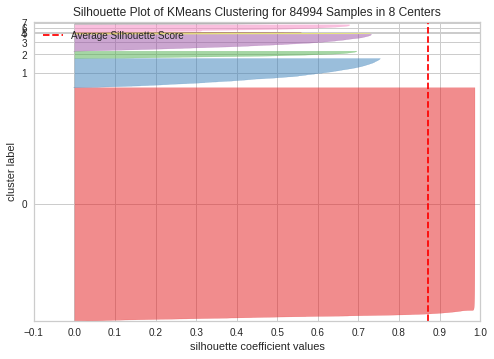

Number of Clusters : 9



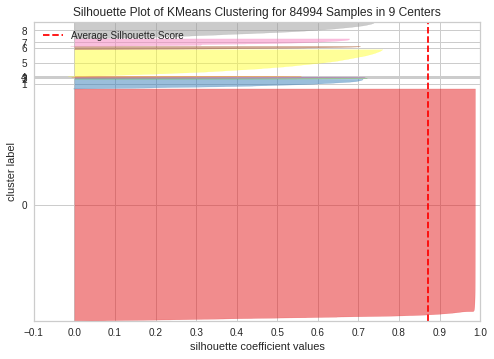

Number of Clusters : 10



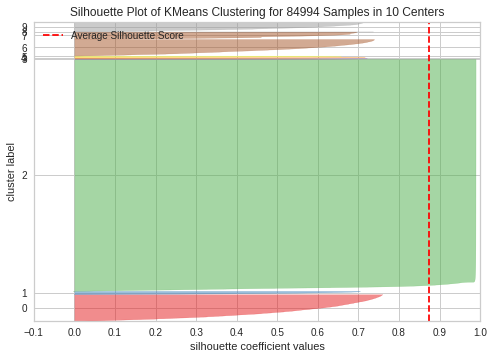

In [32]:
for i in range(6,11):
    print('Number of Clusters : {}\n'.format(i))
    model = KMeans(i)
    visualizer = SilhouetteVisualizer(model)
    
    visualizer.fit(X_pca)
    visualizer.poof()

### DBSCAN ###

#### Testing ####

##### Without the PCA #####

In [10]:
# Find the distances to the nearest neighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# Making a dataframe with its derivatives
distances = np.sort(distances, axis=0)
distances = distances[:,1]
distances_df = pd.DataFrame()
distances_df['distances'] = distances
for i in range(1, len(distances_df)-1):
    y1 = distances_df.loc[i-1, 'distances']
    y2 = distances_df.loc[i+1, 'distances']
    x1 = i-1
    x2 = i+1
    distances_df.loc[i, 'first_derivative'] = (y2-y1)/(x2-x1)
for i in range(2, len(distances_df)-2):
    y1 = distances_df.loc[i-1, 'first_derivative']
    y2 = distances_df.loc[i+1, 'first_derivative']
    x1 = i-1
    x2 = i+1
    distances_df.loc[i, 'second_derivative'] = (y2-y1)/(x2-x1)

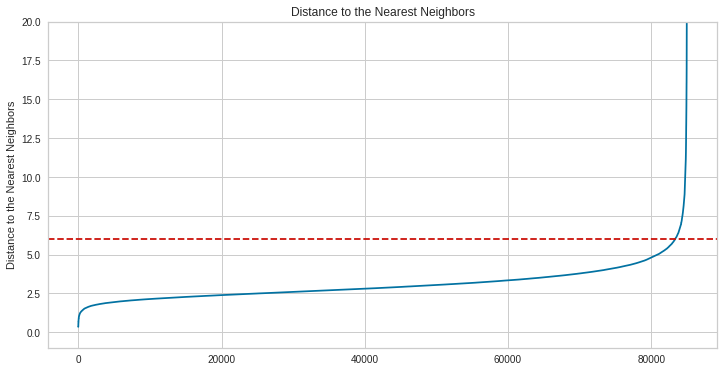

In [11]:
# Best Epsilon
#best_epsilon_line = distances_df[distances_df['second_derivative'] == distances_df['second_derivative'].max()]
#best_epsilon = float(best_epsilon_line['distances'])
#print('The best epsilon value, where the curv is the curve is maximal is :{}\n\n'.format(best_epsilon))

# Ploting
f, ax = plt.subplots(figsize=(12,6))

plt.plot(distances_df['distances'])
plt.axhline(y=6, color='r', linestyle='--')

plt.ylim(-1, 20)
plt.title('Distance to the Nearest Neighbors')
plt.ylabel('Distance to the Nearest Neighbors')
plt.show()

In [1]:
# Compute DBSCAN
t0 = time()
db = DBSCAN(eps=6, min_samples=60, n_jobs = 2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
t1 = time()
elapsed_time = t1 -t0

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print('Homogeneity: %d' % homogeneity_score(X, labels))
#print('Completeness: %d' % completeness_score(X, labels))
#print('Adjusted Rand Score: %d' % adjusted_rand_score(X, labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))
print("Time: %0.3f" % elapsed_time)

# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

NameError: name 'time' is not defined

##### With the PCA #####

In [13]:
# Find the distances to the nearest neighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

# Making a dataframe with its derivatives
distances = np.sort(distances, axis=0)
distances = distances[:,1]
distances_df = pd.DataFrame()
distances_df['distances'] = distances
for i in range(1, len(distances_df)-1):
    y1 = distances_df.loc[i-1, 'distances']
    y2 = distances_df.loc[i+1, 'distances']
    x1 = i-1
    x2 = i+1
    distances_df.loc[i, 'first_derivative'] = (y2-y1)/(x2-x1)
for i in range(2, len(distances_df)-2):
    y1 = distances_df.loc[i-1, 'first_derivative']
    y2 = distances_df.loc[i+1, 'first_derivative']
    x1 = i-1
    x2 = i+1
    distances_df.loc[i, 'second_derivative'] = (y2-y1)/(x2-x1)

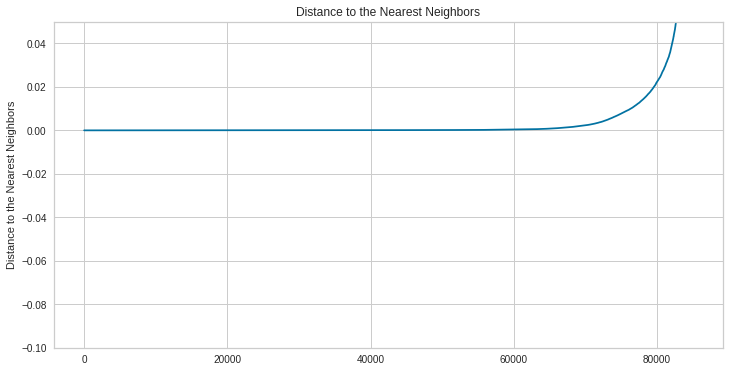

In [18]:
# Best Epsilon
#best_epsilon_line = distances_df[distances_df['second_derivative'] == distances_df['second_derivative'].max()/2]
#best_epsilon = float(best_epsilon_line['distances'])
#print('The best epsilon value, where the curv is the curve is maximal is :{}\n\n'.format(best_epsilon))

# Ploting
f, ax = plt.subplots(figsize=(12,6))

plt.plot(distances_df['distances'])
plt.axhline(y=6, color='r', linestyle='--')

plt.ylim(-0.1, 0.05)
plt.title('Distance to the Nearest Neighbors')
plt.ylabel('Distance to the Nearest Neighbors')
plt.show()

Estimated number of clusters: 0
Estimated number of noise points: 84994
Time: 105.940


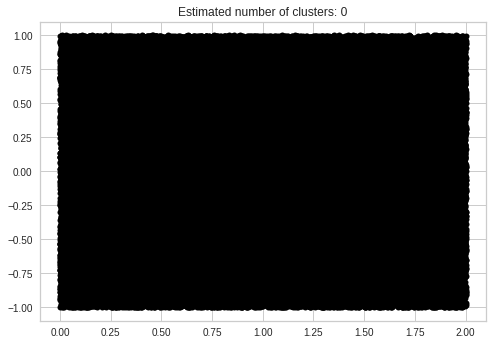

In [20]:
# Compute DBSCAN
t0 = time()
db = DBSCAN(eps=0.02, min_samples=12, n_jobs = 2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
t1 = time()
elapsed_time = t1 -t0

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print('Homogeneity: %d' % homogeneity_score(X, labels))
#print('Completeness: %d' % completeness_score(X, labels))
#print('Adjusted Rand Score: %d' % adjusted_rand_score(X, labels))
#print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))
print("Time: %0.3f" % elapsed_time)

# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### OPTICS ###

#### Testing ####

##### Without the PCA #####

In [22]:
clust = OPTICS(min_samples=12, max_eps=15, cluster_method='dbscan', n_jobs=2)

# Run the fit
clust.fit(X)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=1)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=12)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 1])

# Reachability plot
colors = list(mcolors.TABLEAU_COLORS)
for klass, color in zip(range(0, len([clust.ordering_])), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = list(mcolors.TABLEAU_COLORS)
for klass, color in zip(range(0, len([clust.ordering_])), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

##### With the PCA #####

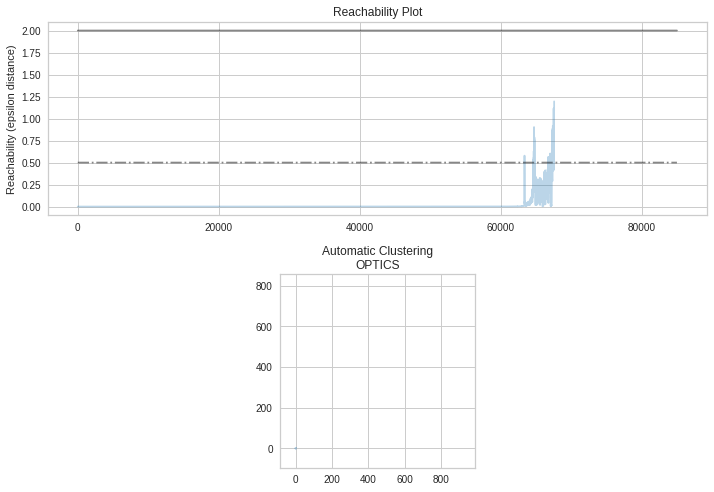

In [23]:
clust = OPTICS(min_samples=12, max_eps=1.2, cluster_method='dbscan', n_jobs=2)

# Run the fit
clust.fit(X_pca)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=1)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=12)

space = np.arange(len(X_pca))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 1])

# Reachability plot
colors = list(mcolors.TABLEAU_COLORS)
for klass, color in zip(range(0, len([clust.ordering_])), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = list(mcolors.TABLEAU_COLORS)
for klass, color in zip(range(0, len([clust.ordering_])), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X_pca[clust.labels_ == -1, 0], X_pca[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

plt.tight_layout()
plt.show()

## Creating and Evaluating the Model ##

We have a silhouette score of 0.8654100345911282 in 1.7539832592010498 seconds. The silhouettes look like :


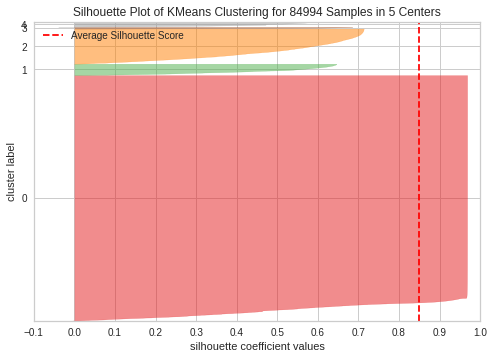

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 84994 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [25]:
# We will chose 4 clusters with the Reduced Data 

t0 = time()
clusterer = KMeans(n_clusters=7).fit(X_pca)
preds = clusterer.predict(X_pca)
t1 = time()
centers = clusterer.cluster_centers_
score = silhouette_score(X_pca, preds, metric='euclidean')
elapsed_time = t1 - t0

print('We have a silhouette score of {} in {} seconds.'.format(score,
                                                               elapsed_time),
     'The silhouettes look like :')

model = KMeans(5)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(X_pca)
visualizer.poof()

The clusters looks like that:


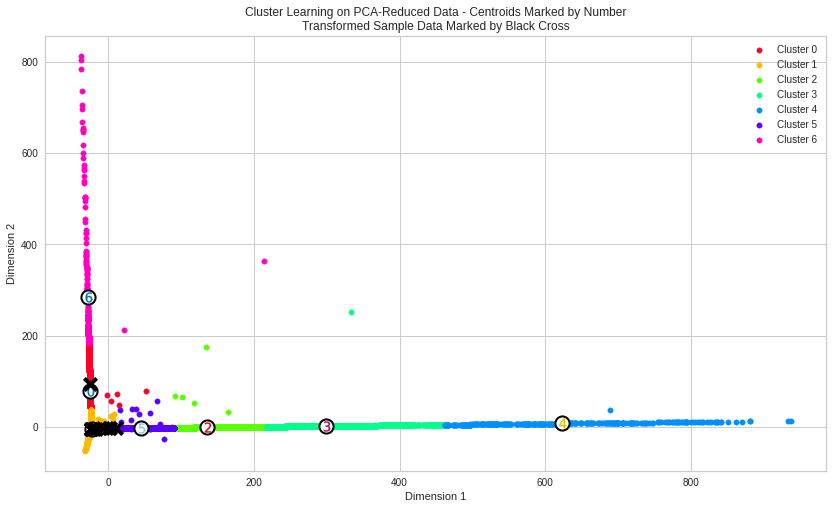

In [26]:
print('The clusters looks like that:')

indices_list = np.random.randint(low=0, high=len(data_df), size=24)
samples = pd.DataFrame(data_df.loc[indices_list], 
                       columns=data_df.columns
                      ).reset_index(drop=True)

samples_X = preprocessing.fit_transform(samples)
pca_samples = pca.transform(samples_X)
reduced_data_df = pd.DataFrame(X_pca, columns = ['Dimension 1', 'Dimension 2'])

cluster_results(reduced_data_df, preds, centers, pca_samples)

In [27]:
true_centers = pca.inverse_transform(centers)
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers_df = pd.DataFrame(np.round(true_centers), columns = data_df.columns)
true_centers_df.index = segments
display(true_centers_df)

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,order_id,order_purchase_timestamp,nb_day_delivery_est,nb_day_delivery_diff_est,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Segment 0,1.0,-0.0,0.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 1,1.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 2,1.0,-0.0,0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 3,1.0,-0.0,0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 4,1.0,-0.0,1.0,-0.0,-0.0,1.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 5,1.0,-0.0,0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 6,1.0,-0.0,0.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
display(true_centers_df - data_df.median())

,Apr,Aug,Dec,Feb,Fri,Jan,Jul,Jun,Mar,May,...,product_description_lenght,product_name_lenght,product_photos_qty,product_vol,product_weight_g,recent_score,review_score,shipped,tot_order_log,unavailable
Segment 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-613.0,-52.0,-2.0,-6314.666667,-674.0,-505.0,-6.0,0.0,-2.626198,0.0
Segment 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-613.0,-52.0,-2.0,-6315.666667,-674.0,-505.0,-6.0,0.0,-4.626198,0.0
Segment 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-613.0,-52.0,-2.0,-6314.666667,-673.0,-505.0,-6.0,0.0,-4.626198,0.0
Segment 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-612.0,-52.0,-2.0,-6314.666667,-673.0,-505.0,-6.0,0.0,-3.626198,-0.0
Segment 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-612.0,-52.0,-2.0,-6313.666667,-671.0,-505.0,-6.0,0.0,-3.626198,-0.0
Segment 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-613.0,-52.0,-2.0,-6314.666667,-674.0,-505.0,-6.0,0.0,-4.626198,0.0
Segment 6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-613.0,-52.0,-2.0,-6314.666667,-673.0,-505.0,-6.0,0.0,2.373802,-0.0


In [29]:
display(true_centers_df - data_df.mean())

,Apr,Aug,Dec,Feb,Fri,Jan,Jul,Jun,Mar,May,...,product_description_lenght,product_name_lenght,product_photos_qty,product_vol,product_weight_g,recent_score,review_score,shipped,tot_order_log,unavailable
Segment 0,-0.094313,-0.110431,-0.058169,-0.085135,-0.141634,-0.080935,-0.104949,-0.095454,-0.099454,-0.105925,...,-789.295424,-48.922859,-2.274269,-14734.927072,-2032.652134,-485.416735,-5.145835,-0.011624,-2.729255,-0.000047
Segment 1,-0.094313,-0.110431,-0.058169,-0.085135,-0.141634,-0.080935,-0.104949,-0.095454,-0.099454,-0.105925,...,-789.295424,-48.922859,-2.274269,-14735.927072,-2032.652134,-485.416735,-5.145835,-0.011624,-4.729255,-0.000047
Segment 2,-0.094313,-0.110431,-0.058169,-0.085135,-0.141634,-0.080935,-0.104949,-0.095454,-0.099454,-0.105925,...,-789.295424,-48.922859,-2.274269,-14734.927072,-2031.652134,-485.416735,-5.145835,-0.011624,-4.729255,-0.000047
Segment 3,-0.094313,-0.110431,-0.058169,-0.085135,-0.141634,-0.080935,-0.104949,-0.095454,-0.099454,-0.105925,...,-788.295424,-48.922859,-2.274269,-14734.927072,-2031.652134,-485.416735,-5.145835,-0.011624,-3.729255,-0.000047
Segment 4,-0.094313,-0.110431,-0.058169,-0.085135,-0.141634,-0.080935,-0.104949,-0.095454,-0.099454,-0.105925,...,-788.295424,-48.922859,-2.274269,-14733.927072,-2029.652134,-485.416735,-5.145835,-0.011624,-3.729255,-0.000047
Segment 5,-0.094313,-0.110431,-0.058169,-0.085135,-0.141634,-0.080935,-0.104949,-0.095454,-0.099454,-0.105925,...,-789.295424,-48.922859,-2.274269,-14734.927072,-2032.652134,-485.416735,-5.145835,-0.011624,-4.729255,-0.000047
Segment 6,-0.094313,-0.110431,-0.058169,-0.085135,-0.141634,-0.080935,-0.104949,-0.095454,-0.099454,-0.105925,...,-789.295424,-48.922859,-2.274269,-14734.927072,-2031.652134,-485.416735,-5.145835,-0.011624,2.270745,-0.000047


In [90]:
mean_test_df = (true_centers_df - data_df.mean())
median_test_df = (true_centers_df - data_df.median())

for col in mean_test_df.columns:
    print(mean_test_df[col])
    print(median_test_df[col])

Segment 0   -0.094313
Segment 1   -0.094313
Segment 2   -0.094313
Segment 3   -0.094313
Segment 4   -0.094313
Segment 5   -0.094313
Segment 6   -0.094313
Name: Apr, dtype: float64
Segment 0    0.0
Segment 1    0.0
Segment 2    0.0
Segment 3    0.0
Segment 4    0.0
Segment 5    0.0
Segment 6    0.0
Name: Apr, dtype: float64
Segment 0   -0.110431
Segment 1   -0.110431
Segment 2   -0.110431
Segment 3   -0.110431
Segment 4   -0.110431
Segment 5   -0.110431
Segment 6   -0.110431
Name: Aug, dtype: float64
Segment 0    0.0
Segment 1    0.0
Segment 2    0.0
Segment 3    0.0
Segment 4    0.0
Segment 5    0.0
Segment 6    0.0
Name: Aug, dtype: float64
Segment 0   -0.058169
Segment 1   -0.058169
Segment 2   -0.058169
Segment 3   -0.058169
Segment 4   -0.058169
Segment 5   -0.058169
Segment 6   -0.058169
Name: Dec, dtype: float64
Segment 0    0.0
Segment 1    0.0
Segment 2    0.0
Segment 3    0.0
Segment 4    0.0
Segment 5    0.0
Segment 6    0.0
Name: Dec, dtype: float64
Segment 0   -0.085135
Seg